In [54]:
import pandas as pd
import numpy as np
import ta
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import optuna
import yfinance as yf

# Para el análisis de features
import scipy.stats as stats

In [64]:
class ForexPredictor:
    def __init__(self, time_steps=20, test_size=0.2):
        self.time_steps = time_steps
        self.test_size = test_size
        self.scaler = MinMaxScaler()
        self.model = None
        
    def prepare_features(self, df):
        """
        Preparación mejorada de características
        """
        # Retornos y volatilidad
        df['Returns'] = df['Close'].pct_change()
        df['Log_Returns'] = np.log(df['Close']).diff()
        df['Volatility'] = df['Returns'].rolling(window=self.time_steps).std()
        
        # Características de volatilidad avanzadas
        df['Volatility_Parkinson'] = np.sqrt((1.0 / (4.0 * np.log(2.0))) * 
                                           np.log(df['High']/df['Low'])**2)
        
        # Características de liquidez y spread
        df['Spread_Pct'] = (df['Ask'] - df['Bid']) / df['Close']
        df['Spread_Volatility'] = df['Spread_Pct'].rolling(window=self.time_steps).std()
        
        # Características temporales
        df['Day_of_Week'] = df.index.dayofweek
        df['Month'] = df.index.month
        df['Quarter'] = df.index.quarter
        
        # Indicadores técnicos avanzados
        df['RSI'] = ta.momentum.RSIIndicator(df['Close']).rsi()
        macd = ta.trend.MACD(df['Close'])
        df['MACD'] = macd.macd()
        df['MACD_Signal'] = macd.macd_signal()
        df['MACD_Diff'] = macd.macd_diff()
        
        bollinger = ta.volatility.BollingerBands(df['Close'])
        df['BB_High'] = bollinger.bollinger_hband()
        df['BB_Low'] = bollinger.bollinger_lband()
        df['BB_Width'] = (df['BB_High'] - df['BB_Low']) / df['Close']
        
        df['ADX'] = ta.trend.ADXIndicator(df['High'], df['Low'], df['Close']).adx()
        df['ATR'] = ta.volatility.AverageTrueRange(
            high=df['High'], low=df['Low'], close=df['Close']
        ).average_true_range()
        
        return df
    
    def create_target(self, df, threshold_std=0.5):
        """
        Target más sofisticado basado en retornos futuros y volatilidad
        """
        df['Future_Returns'] = df['Returns'].shift(-1)
        df['Rolling_Std'] = df['Returns'].rolling(window=20).std()
        threshold_std = df['Rolling_Std'].quantile(0.75)
        # Target considerando la volatilidad histórica
        df['Target'] = np.where(
            df['Future_Returns'] > df['Rolling_Std'] * threshold_std, 
            1, 
            0
        )
        
        return df
    
    def add_macro_data(self, df):
        """
        Añade datos macroeconómicos relevantes para USDPEN
        """
        try:
            # Descargar datos relevantes de Yahoo Finance
            start_date = df.index[0]
            end_date = df.index[-1]
            
            # Índice DXY (Dólar Index)
            dxy = yf.download('DX-Y.NYB', start=start_date, end=end_date)['Close']
            df['DXY_Returns'] = dxy.pct_change()
            
            # Precio del cobre (relevante para Perú)
            copper = yf.download('HG=F', start=start_date, end=end_date)['Close']
            df['Copper_Returns'] = copper.pct_change()
            
            # S&P 500 como proxy de sentimiento global
            sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Close']
            df['SP500_Returns'] = sp500.pct_change()
            
        except Exception as e:
            print(f"Error al obtener datos macro: {e}")
            
        return df
    
    def create_sequences(self, X, y):
        """
        Crea secuencias para el modelo LSTM
        """
        Xs, ys = [], []
        for i in range(len(X) - self.time_steps):
            Xs.append(X[i:(i + self.time_steps)])
            ys.append(y[i + self.time_steps])
        return np.array(Xs), np.array(ys)
    
    def focal_loss(self, y_true, y_pred, gamma=2.0, alpha=0.25):
        # Añadir como método de la clase
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.keras.backend.clip(y_pred, epsilon, 1.0 - epsilon)
        loss = -y_true * alpha * tf.math.pow(1 - y_pred, gamma) * tf.math.log(y_pred) - \
            (1 - y_true) * (1 - alpha) * tf.math.pow(y_pred, gamma) * tf.math.log(1 - y_pred)
        return tf.reduce_mean(loss)
    
    def create_model(self, input_shape, trial=None):
        """
        Crea modelo con arquitectura optimizable
        """
        if trial is None:
            # Configuración por defecto
            n_layers = 3
            units = [128, 64, 32]
            dropout_rate = 0.3
        else:
            # Configuración con Optuna
            n_layers = trial.suggest_int('n_layers', 2, 4)
            units = [trial.suggest_int(f'n_units_l{i}', 32, 256) for i in range(n_layers)]
            dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
        
        model = Sequential([BatchNormalization(input_shape=input_shape)])
        
        for i in range(n_layers):
            return_sequences = i < n_layers - 1
            model.add(Bidirectional(LSTM(
                units[i],
                return_sequences=return_sequences,
                kernel_regularizer=tf.keras.regularizers.l2(0.01),  # Aumentar regularización
                recurrent_regularizer=tf.keras.regularizers.l2(0.01),  # Agregar regularización recurrente
                bias_regularizer=tf.keras.regularizers.l2(0.01)  # Agregar regularización del bias
            )))
            model.add(Dropout(dropout_rate))
            model.add(BatchNormalization())
        
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(dropout_rate/2))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        
        # Learning rate schedule
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            0.001, decay_steps=1000, decay_rate=0.9
        )
        
        model.compile(
            optimizer=Adam(learning_rate=lr_schedule),
            loss=self.focal_loss,
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
        )
        
        return model
    
    def select_features(self, X, y, n_features=10):
        """
        Selecciona las mejores features usando mutual information
        """
        selector = SelectKBest(score_func=mutual_info_classif, k=n_features)
        selector.fit(X, y)
        
        # Guardar los índices de las features seleccionadas
        self.selected_features_idx = selector.get_support(indices=True)
        self.feature_scores = selector.scores_
        
        return selector.transform(X), selector.get_feature_names_out()
    
    def objective(self, trial, X_train, y_train, X_val, y_val):
        """
        Función objetivo para optimización con Optuna
        """
        model = self.create_model(
            input_shape=(self.time_steps, X_train.shape[2]),
            trial=trial
        )
        
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=batch_size,
            callbacks=[EarlyStopping(monitor='val_auc', patience=10, mode='max')],
            verbose=0
        )
        
        return max(history.history['val_auc'])
    
    def optimize_hyperparameters(self, X_train, y_train, X_val, y_val):
        """
        Optimización de hiperparámetros con Optuna
        """
        study = optuna.create_study(direction='maximize')
        study.optimize(
            lambda trial: self.objective(trial, X_train, y_train, X_val, y_val),
            n_trials=50
        )
        return study.best_trial
    
    def train(self, X_train, y_train, X_val, y_val, optimize=True):
        """
        Entrenamiento del modelo con optimización opcional
        """
        if optimize:
            best_trial = self.optimize_hyperparameters(X_train, y_train, X_val, y_val)
            self.model = self.create_model(
                input_shape=(self.time_steps, X_train.shape[2]),
                trial=best_trial
            )
        else:
            self.model = self.create_model(
                input_shape=(self.time_steps, X_train.shape[2])
            )
        
        # Calcular pesos de clase
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        class_weights[0]*=2 # Penalizar falsos positivos
        class_weight_dict = dict(enumerate(class_weights))
        
        # Callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_auc',
                mode='max',
                patience=15,
                restore_best_weights=True
            ),
            ReduceLROnPlateau(
                monitor='val_auc',
                mode='max',
                factor=0.5,
                patience=5,
                min_lr=1e-6
            ),
            ModelCheckpoint(
                'best_model.h5',
                monitor='val_auc',
                mode='max',
                save_best_only=True
            )
        ]
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=100,
            batch_size=32,
            class_weight=class_weight_dict,
            callbacks=callbacks
        )
        
        return history
    
    def evaluate(self, X_test, y_test):
        """
        Evaluación comprehensiva del modelo
        """
        y_pred_proba = self.model.predict(X_test)
        
        # Encontrar mejor umbral
        thresholds = np.arange(0.3, 0.7, 0.05)
        best_f1 = 0
        best_threshold = 0.5
        
        for threshold in thresholds:
            y_pred = (y_pred_proba > threshold).astype(int)
            f1 = f1_score(y_test, y_pred)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        y_pred = (y_pred_proba > best_threshold).astype(int)
        
        # Métricas
        print("\nMétricas de Evaluación:")
        print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
        print(f"Best Threshold: {best_threshold:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        
        return y_pred, best_threshold
    
    def backtest(self, df, predictions, initial_capital=10000, transaction_cost=0.0001):
        """
        Backtesting mejorado con costos de transacción y métricas de riesgo
        """
        df_backtest = df[-len(predictions):].copy()
        df_backtest['Prediction'] = predictions
        df_backtest['Returns'] = df_backtest['Close'].pct_change()
        
        # Añadir costos de transacción
        df_backtest['Position_Change'] = df_backtest['Prediction'].diff().abs()
        df_backtest['Transaction_Costs'] = df_backtest['Position_Change'] * transaction_cost
        
        # Calcular retornos de la estrategia
        df_backtest['Strategy_Returns'] = (
            df_backtest['Returns'] * df_backtest['Prediction'] - 
            df_backtest['Transaction_Costs']
        )
        
        df_backtest['Cumulative_Returns'] = (
            1 + df_backtest['Strategy_Returns']
        ).cumprod()
        
        # Métricas de riesgo
        strategy_returns = df_backtest['Strategy_Returns']
        risk_free_rate = 0.01  # Tasa libre de riesgo anual
        
        sharpe = (
            np.sqrt(252) * (strategy_returns.mean() - risk_free_rate/252) / 
            strategy_returns.std()
        )
        
        max_drawdown = (
            (df_backtest['Cumulative_Returns'].cummax() - 
             df_backtest['Cumulative_Returns']) / 
            df_backtest['Cumulative_Returns'].cummax()
        ).max()
        
        final_capital = initial_capital * df_backtest['Cumulative_Returns'].iloc[-1]
        
        print("\nBacktesting Results:")
        print(f"Initial Capital: ${initial_capital:,.2f}")
        print(f"Final Capital: ${final_capital:,.2f}")
        print(f"Total Return: {((final_capital/initial_capital - 1) * 100):.2f}%")
        print(f"Sharpe Ratio: {sharpe:.2f}")
        print(f"Maximum Drawdown: {max_drawdown*100:.2f}%")
        
        return df_backtest

In [15]:
def main():
    """
    Ejemplo completo de uso del ForexPredictor
    """
    # Cargar datos
    data = pd.read_csv("USDPEN.csv")
    data['Dates'] = pd.to_datetime(data['Dates'], format='%d/%m/%Y')
    data.set_index('Dates', inplace=True)
    
    # Crear instancia del predictor
    predictor = ForexPredictor(time_steps=20)
    
    # Preparar datos
    print("Preparando datos...")
    df = predictor.prepare_features(data)
    df = predictor.create_target(df)
    df = predictor.add_macro_data(df)
    df = df.dropna()
    
    # Seleccionar features
    features = [col for col in df.columns if col not in ['Target', 'Future_Returns']]
    X = df[features].values
    y = df['Target'].values
    
    # Crear secuencias
    X_seq, y_seq = predictor.create_sequences(X, y)
    
    # Time Series Split
    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(X_seq):
        # División train/validation/test
        X_train, X_test = X_seq[train_index], X_seq[test_index]
        y_train, y_test = y_seq[train_index], y_seq[test_index]
        
        # Separar validación del conjunto de entrenamiento
        val_size = int(len(X_train) * 0.2)
        X_val = X_train[-val_size:]
        y_val = y_train[-val_size:]
        X_train = X_train[:-val_size]
        y_train = y_train[:-val_size]
        
        # Escalar datos
        scaler = MinMaxScaler()
        X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
        X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
        X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
        
        X_train_scaled = scaler.fit_transform(X_train_reshaped)
        X_val_scaled = scaler.transform(X_val_reshaped)
        X_test_scaled = scaler.transform(X_test_reshaped)
        
        X_train = X_train_scaled.reshape(X_train.shape)
        X_val = X_val_scaled.reshape(X_val.shape)
        X_test = X_test_scaled.reshape(X_test.shape)
        
        print("\nEntrenando modelo...")
        # Entrenar modelo con optimización de hiperparámetros
        history = predictor.train(
            X_train, y_train,
            X_val, y_val,
            optimize=True  # Establecer False para saltarse la optimización
        )
        
        print("\nEvaluando modelo...")
        # Evaluar modelo
        y_pred, best_threshold = predictor.evaluate(X_test, y_test)
        
        print("\nRealizando backtesting...")
        # Realizar backtesting
        backtest_results = predictor.backtest(
            df,
            y_pred,
            initial_capital=10000,
            transaction_cost=0.0001
        )
        
        # Plot de resultados
        plt.figure(figsize=(15, 7))
        plt.plot(backtest_results.index, backtest_results['Cumulative_Returns'])
        plt.title('Retornos Acumulados de la Estrategia')
        plt.xlabel('Fecha')
        plt.ylabel('Retorno Acumulado')
        plt.grid(True)
        plt.show()
        
        # Solo ejecutamos una iteración del cross-validation para este ejemplo
        break



In [16]:
if __name__ == "__main__":
    main()

[*********************100%%**********************]  1 of 1 completed

Preparando datos...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[I 2024-12-17 02:58:33,386] A new study created in memory with name: no-name-90aea091-25f1-4fdb-89fc-3c4726c3f7e1



Entrenando modelo...


[I 2024-12-17 03:01:22,812] Trial 0 finished with value: 0.5982339978218079 and parameters: {'n_layers': 3, 'n_units_l0': 111, 'n_units_l1': 140, 'n_units_l2': 166, 'dropout_rate': 0.4314703410865226, 'batch_size': 64}. Best is trial 0 with value: 0.5982339978218079.
[I 2024-12-17 03:06:37,797] Trial 1 finished with value: 0.6546725630760193 and parameters: {'n_layers': 4, 'n_units_l0': 139, 'n_units_l1': 232, 'n_units_l2': 153, 'n_units_l3': 199, 'dropout_rate': 0.21176242879076934, 'batch_size': 16}. Best is trial 1 with value: 0.6546725630760193.
[I 2024-12-17 03:08:44,294] Trial 2 finished with value: 0.590213418006897 and parameters: {'n_layers': 3, 'n_units_l0': 50, 'n_units_l1': 59, 'n_units_l2': 203, 'dropout_rate': 0.250384069346942, 'batch_size': 16}. Best is trial 1 with value: 0.6546725630760193.
[I 2024-12-17 03:10:55,076] Trial 3 finished with value: 0.5944076180458069 and parameters: {'n_layers': 3, 'n_units_l0': 49, 'n_units_l1': 180, 'n_units_l2': 32, 'dropout_rate': 0

KeyboardInterrupt: 

[*********************100%%**********************]  1 of 1 completed

Preparando datos...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Pesos por clase:
Clase 0 (Baja): 0.97
Clase 1 (Sube): 1.03

Creando modelo con los mejores parámetros del trial 14...
Epoch 1/50
25/25 [==============================] - 20s 445ms/step - loss: 8.2997 - accuracy: 0.5025 - auc: 0.4874 - val_loss: 6.9792 - val_accuracy: 0.5000 - val_auc: 0.4930 - lr: 9.9747e-04
Epoch 2/50
25/25 [==============================] - 9s 379ms/step - loss: 5.9936 - accuracy: 0.5317 - auc: 0.5413 - val_loss: 4.9959 - val_accuracy: 0.4337 - val_auc: 0.4479 - lr: 9.9485e-04
Epoch 3/50
25/25 [==============================] - 10s 390ms/step - loss: 4.2949 - accuracy: 0.5850 - auc: 0.5828 - val_loss: 3.6307 - val_accuracy: 0.4847 - val_auc: 0.4781 - lr: 9.9223e-04
Epoch 4/50
25/25 [==============================] - 9s 379ms/step - loss: 3.1832 - accuracy: 0.5266 - auc: 0.5427 - val_loss: 2.7392 - val_accuracy: 0.5204 - val_auc: 0.5520 - lr: 9.8962e-04
Epoch 5/50
25/25 [==============================] - 9s 378ms/step - loss: 2.4514 - accuracy: 0.5584 - auc: 0.5467 -

C:\Users\Carlos Palma\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Carlos Palma\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Carlos Palma\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

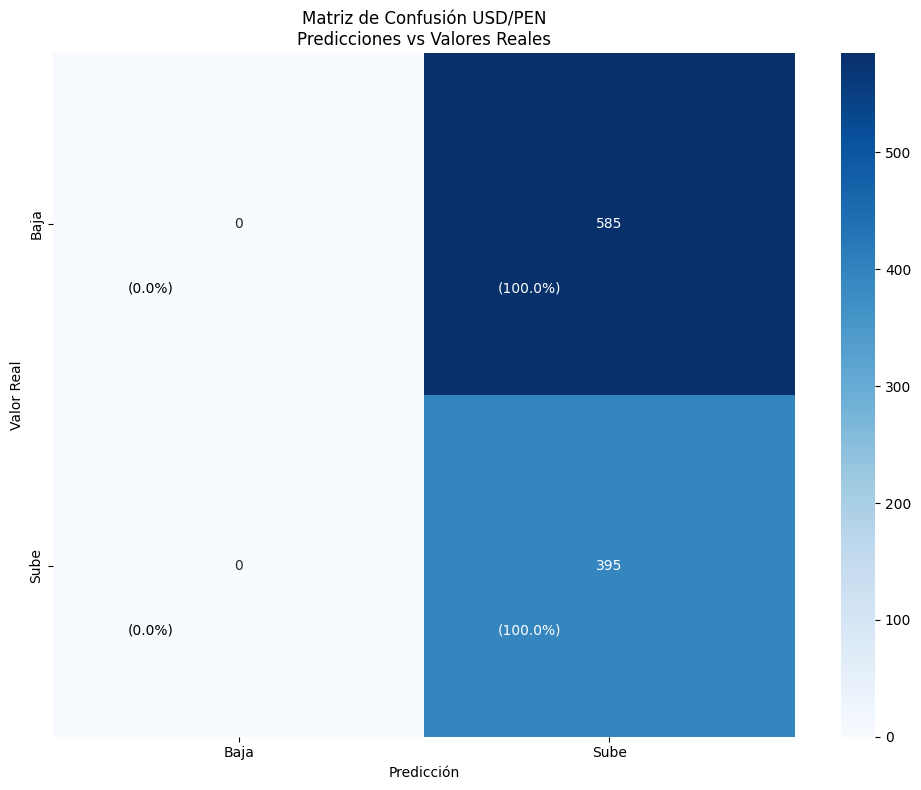

C:\Users\Carlos Palma\AppData\Local\Temp\ipykernel_26260\2685008984.py:131: RuntimeWarning: invalid value encountered in scalar divide
  print(f"Precisión en bajadas: {cm[0,0]/(cm[0,0]+cm[1,0]):.1%}")



Métricas por Clase:
Accuracy en bajadas: 0.0%
Accuracy en subidas: 100.0%
Precisión en bajadas: nan%
Precisión en subidas: 40.3%

Realizando backtesting...

Backtesting Results:
Initial Capital: $10,000.00
Final Capital: $10,331.60
Total Return: 3.32%
Sharpe Ratio: 0.02
Maximum Drawdown: 14.03%

Analizando retornos por tipo de predicción...


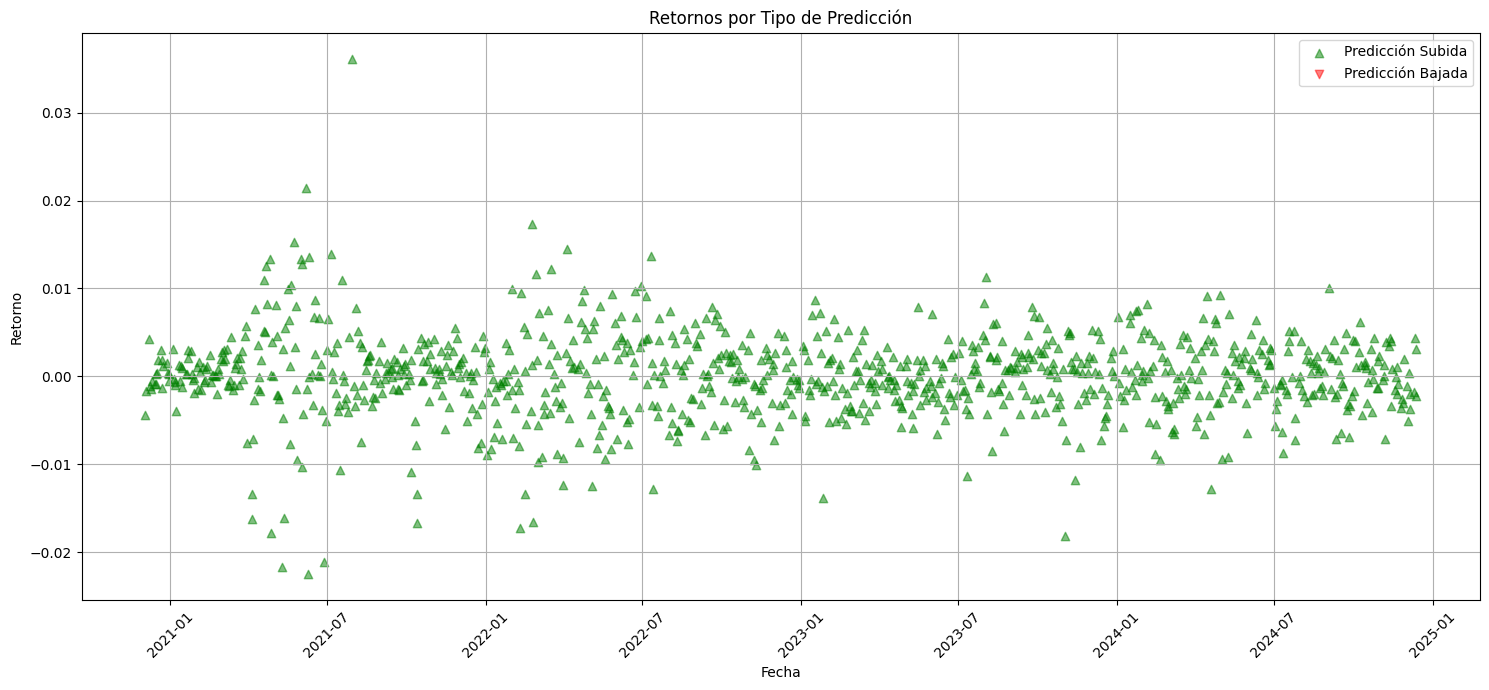


Estadísticas de retornos:
Predicciones de subida:
- Número de predicciones: 980
- Retorno promedio: 0.0045%

Predicciones de bajada:
- Número de predicciones: 0
- Retorno promedio: nan%

Guardando el modelo...
INFO:tensorflow:Assets written to: best_forex_model_final\assets


INFO:tensorflow:Assets written to: best_forex_model_final\assets


In [46]:
def main():
    # Cargar datos
    data = pd.read_csv("USDPEN.csv")
    data['Dates'] = pd.to_datetime(data['Dates'], format='%d/%m/%Y')
    data.set_index('Dates', inplace=True)
    
    # Crear instancia del predictor
    predictor = ForexPredictor(time_steps=20)
    
    # Preparar datos
    print("Preparando datos...")
    df = predictor.prepare_features(data)
    df = predictor.create_target(df)
    df = predictor.add_macro_data(df)
    df = df.dropna()
    
    # Seleccionar features
    features = [col for col in df.columns if col not in ['Target', 'Future_Returns']]
    X = df[features].values
    y = df['Target'].values
    
    # Crear secuencias
    X_seq, y_seq = predictor.create_sequences(X, y)
    
    # Time Series Split
    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(X_seq):
        # División train/validation/test
        X_train, X_test = X_seq[train_index], X_seq[test_index]
        y_train, y_test = y_seq[train_index], y_seq[test_index]
        
        # Separar validación
        val_size = int(len(X_train) * 0.2)
        X_val = X_train[-val_size:]
        y_val = y_train[-val_size:]
        X_train = X_train[:-val_size]
        y_train = y_train[:-val_size]
        
        # Escalar datos
        scaler = MinMaxScaler()
        X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
        X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
        X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
        
        X_train_scaled = scaler.fit_transform(X_train_reshaped)
        X_val_scaled = scaler.transform(X_val_reshaped)
        X_test_scaled = scaler.transform(X_test_reshaped)
        
        X_train = X_train_scaled.reshape(X_train.shape)
        X_val = X_val_scaled.reshape(X_val.shape)
        X_test = X_test_scaled.reshape(X_test.shape)
        
        # Calcular pesos de clase
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        class_weight_dict = dict(zip(np.unique(y_train), class_weights))
        print("\nPesos por clase:")
        print(f"Clase 0 (Baja): {class_weight_dict[0]:.2f}")
        print(f"Clase 1 (Sube): {class_weight_dict[1]:.2f}")
        
        print("\nCreando modelo con los mejores parámetros del trial 14...")
        best_params = {
            'n_layers': 4,
            'n_units_l0': 251,
            'n_units_l1': 208,
            'n_units_l2': 84,
            'n_units_l3': 33,
            'dropout_rate': 0.4428623617012557,
            'batch_size': 32
        }
        
        predictor.model = predictor.create_model(
            input_shape=(predictor.time_steps, X_train.shape[2])
        )
        
        # Entrenar modelo
        history = predictor.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=best_params['batch_size'],
            class_weight=class_weight_dict,
            callbacks=[
                EarlyStopping(
                    monitor='val_auc',
                    mode='max',
                    patience=15,
                    restore_best_weights=True
                ),
                ReduceLROnPlateau(
                    monitor='val_auc',
                    mode='max',
                    factor=0.5,
                    patience=5,
                    min_lr=1e-6
                )
            ]
        )
        
        print("\nEvaluando modelo...")
        y_pred, best_threshold = predictor.evaluate(X_test, y_test)
        
        # Matriz de confusión con visualización mejorada
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(y_test, y_pred)
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Baja', 'Sube'],
                    yticklabels=['Baja', 'Sube'])
        
        # Agregar porcentajes
        for i in range(2):
            for j in range(2):
                plt.text(j+0.2, i+0.7, f'({cm_norm[i,j]:.1%})', 
                        color='white' if cm[i,j] > 100 else 'black')
        
        plt.title('Matriz de Confusión USD/PEN\nPredicciones vs Valores Reales')
        plt.ylabel('Valor Real')
        plt.xlabel('Predicción')
        plt.tight_layout()
        plt.show()
        
        # Métricas detalladas
        print("\nMétricas por Clase:")
        print(f"Accuracy en bajadas: {cm[0,0]/sum(cm[0,:]):.1%}")
        print(f"Accuracy en subidas: {cm[1,1]/sum(cm[1,:]):.1%}")
        print(f"Precisión en bajadas: {cm[0,0]/(cm[0,0]+cm[1,0]):.1%}")
        print(f"Precisión en subidas: {cm[1,1]/(cm[1,1]+cm[0,1]):.1%}")
        
        print("\nRealizando backtesting...")
        backtest_results = predictor.backtest(
            df,
            y_pred,
            initial_capital=10000,
            transaction_cost=0.0001
        )
        
        # Análisis de retornos por tipo de predicción
        # Reemplaza la parte del código de visualización así:
        print("\nAnalizando retornos por tipo de predicción...")

        # Convertir resultados a DataFrame y alinear índices
        backtest_df = pd.DataFrame(backtest_results)
        backtest_df = backtest_df.iloc[-len(y_pred):]

        # Añadir predicciones al DataFrame
        backtest_df['Prediction'] = y_pred

        # Separar por tipo de predicción
        subidas = backtest_df[backtest_df['Prediction'] == 1]
        bajadas = backtest_df[backtest_df['Prediction'] == 0]

        plt.figure(figsize=(15, 7))

        # Graficar usando los DataFrames filtrados
        plt.scatter(subidas.index, subidas['Strategy_Returns'],
                c='green', marker='^', label='Predicción Subida', alpha=0.5)
        plt.scatter(bajadas.index, bajadas['Strategy_Returns'],
                c='red', marker='v', label='Predicción Bajada', alpha=0.5)

        plt.title('Retornos por Tipo de Predicción')
        plt.xlabel('Fecha')
        plt.ylabel('Retorno')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Estadísticas de retornos
        print("\nEstadísticas de retornos:")
        print("Predicciones de subida:")
        print(f"- Número de predicciones: {len(subidas)}")
        print(f"- Retorno promedio: {subidas['Strategy_Returns'].mean():.4%}")
        print("\nPredicciones de bajada:")
        print(f"- Número de predicciones: {len(bajadas)}")
        print(f"- Retorno promedio: {bajadas['Strategy_Returns'].mean():.4%}")
        
        # Guardar el modelo
        print("\nGuardando el modelo...")
        predictor.model.save('best_forex_model_final')
        
        break  # Solo una iteración

if __name__ == "__main__":
    main()

In [66]:
# Cargar datos
data = pd.read_csv("USDPEN.csv")
data['Dates'] = pd.to_datetime(data['Dates'], format='%d/%m/%Y')
data.set_index('Dates', inplace=True)

# Crear instancia del predictor
predictor = ForexPredictor(time_steps=20)

print("Preparando datos...")
df = predictor.prepare_features(data)
df = predictor.create_target(df)
df = predictor.add_macro_data(df)
df = df.dropna()

# Ver las features disponibles
print("\nFeatures disponibles:")
features = [col for col in df.columns if col not in ['Target', 'Future_Returns']]
print(f"Número total de features: {len(features)}")
print(f"Features: {features}")

[*********************100%%**********************]  1 of 1 completed

Preparando datos...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Features disponibles:
Número total de features: 28
Features: ['Open', 'High', 'Low', 'Close', 'Bid', 'Ask', 'Returns', 'Log_Returns', 'Volatility', 'Volatility_Parkinson', 'Spread_Pct', 'Spread_Volatility', 'Day_of_Week', 'Month', 'Quarter', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_High', 'BB_Low', 'BB_Width', 'ADX', 'ATR', 'Rolling_Std', 'DXY_Returns', 'Copper_Returns', 'SP500_Returns']


In [67]:
# Crear secuencias
X_seq, y_seq = predictor.create_sequences(X, y)

# Time Series Split
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X_seq):
    # División train/validation/test
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]
    
    # Separar validación
    val_size = int(len(X_train) * 0.2)
    X_val = X_train[-val_size:]
    y_val = y_train[-val_size:]
    X_train = X_train[:-val_size]
    y_train = y_train[:-val_size]
    break  # Solo una iteración


Top 10 features por correlación:
RSI                               0.072
ATR                               0.065
BB_High                           0.061
High                              0.060
Ask                               0.060
Bid                               0.060
Close                             0.060
Volatility_Parkinson              0.059
Open                              0.059
Low                               0.059

Top 10 features por mutual information:
Volatility                        0.018
Rolling_Std                       0.018
Low                               0.010
Volatility_Parkinson              0.010
DXY_Returns                       0.010
BB_High                           0.009
Spread_Volatility                 0.009
Spread_Pct                        0.007
MACD_Diff                         0.005
ADX                               0.004


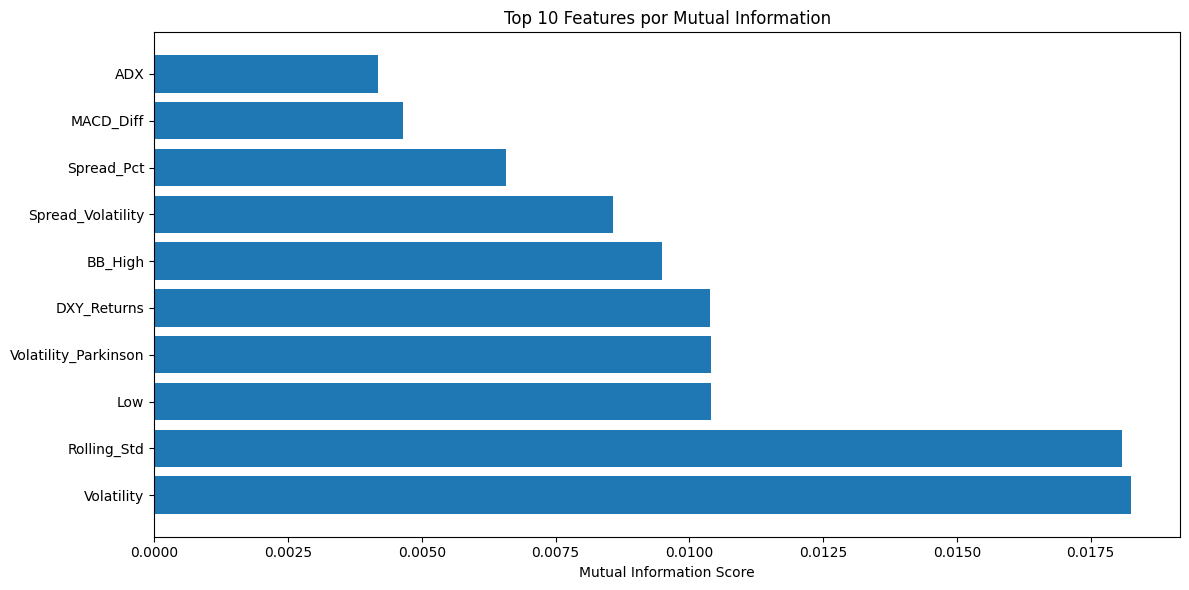

In [68]:
# Análisis de correlación con el target
correlations = []
for feature in features:
    correlation = stats.pointbiserialr(df['Target'], df[feature])[0]
    correlations.append((feature, correlation))

# Ordenar por correlación absoluta
correlations.sort(key=lambda x: abs(x[1]), reverse=True)

# Mostrar top 10 correlaciones
print("\nTop 10 features por correlación:")
for feature, corr in correlations[:10]:
    print(f"{feature:<30} {corr:>8.3f}")

# Crear matriz X y vector y
X = df[features].values
y = df['Target'].values

# Calcular mutual information para cada feature
mi_scores = mutual_info_classif(X, y)

# Ordenar features por mutual information
feature_importance = list(zip(features, mi_scores))
feature_importance.sort(key=lambda x: x[1], reverse=True)

print("\nTop 10 features por mutual information:")
for feature, mi in feature_importance[:10]:
    print(f"{feature:<30} {mi:>8.3f}")

# Visualizar importancia de features
plt.figure(figsize=(12, 6))
features_mi = [x[0] for x in feature_importance[:10]]
scores_mi = [x[1] for x in feature_importance[:10]]

plt.barh(range(len(features_mi)), scores_mi)
plt.yticks(range(len(features_mi)), features_mi)
plt.xlabel('Mutual Information Score')
plt.title('Top 10 Features por Mutual Information')
plt.tight_layout()
plt.show()

In [69]:
# Seleccionar las mejores features basadas en mutual information
top_features = [x[0] for x in feature_importance[:10]]  # Top 10 features
X = df[top_features].values
y = df['Target'].values

# Seleccionar mejores features
X_selected, selected_feature_names = predictor.select_features(X, y, n_features=10)
print(f"\nFeatures seleccionadas: {selected_feature_names}")

# Crear secuencias con las features seleccionadas
X_seq, y_seq = predictor.create_sequences(X_selected, y)

# Time Series Split
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X_seq):
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]
    
    # Separar validación
    val_size = int(len(X_train) * 0.2)
    X_val = X_train[-val_size:]
    y_val = y_train[-val_size:]
    X_train = X_train[:-val_size]
    y_train = y_train[:-val_size]
    break


Features seleccionadas: ['x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x8' 'x9']



Distribución de clases en los conjuntos:

Entrenamiento:
Total muestras: 788
Bajadas (0): 407 (51.6%)
Subidas (1): 381 (48.4%)

Validación:
Total muestras: 196
Bajadas (0): 107 (54.6%)
Subidas (1): 89 (45.4%)

Test:
Total muestras: 980
Bajadas (0): 585 (59.7%)
Subidas (1): 395 (40.3%)


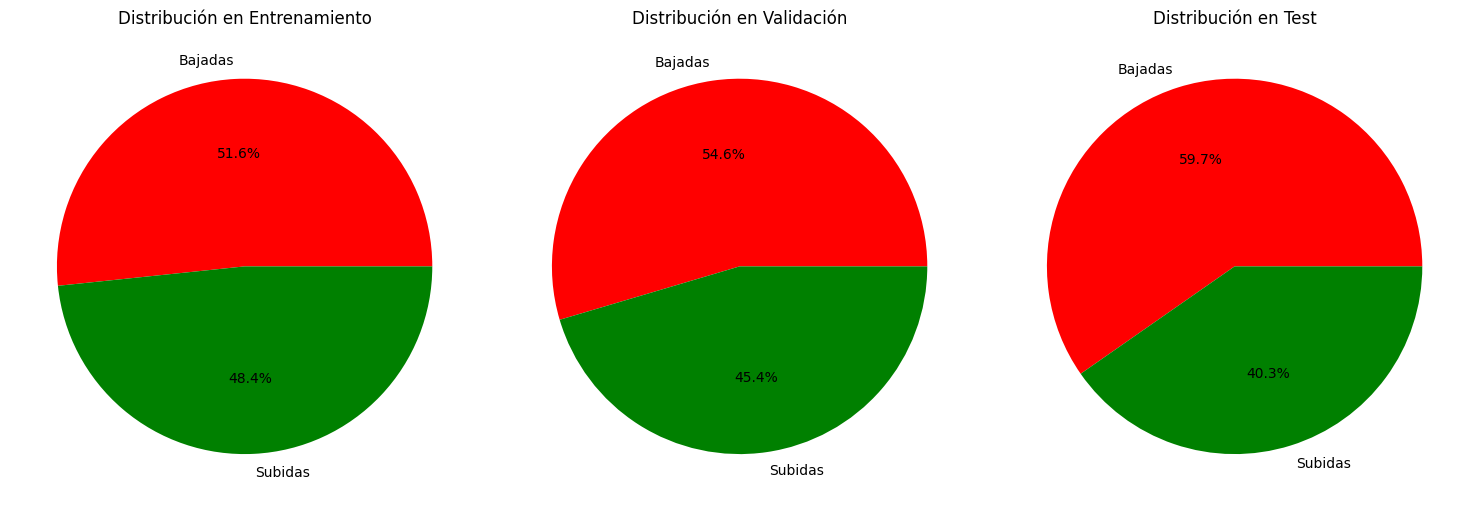

In [70]:
# Análisis de distribución
print("\nDistribución de clases en los conjuntos:")
sets = {'Entrenamiento': y_train, 'Validación': y_val, 'Test': y_test}

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, (name, y_data) in enumerate(sets.items()):
    total = len(y_data)
    bajadas = sum(y_data == 0)
    subidas = sum(y_data == 1)
    
    print(f"\n{name}:")
    print(f"Total muestras: {total}")
    print(f"Bajadas (0): {bajadas} ({bajadas/total:.1%})")
    print(f"Subidas (1): {subidas} ({subidas/total:.1%})")
    
    axs[i].pie([bajadas, subidas], 
               labels=['Bajadas', 'Subidas'],
               autopct='%1.1f%%',
               colors=['red', 'green'])
    axs[i].set_title(f'Distribución en {name}')

plt.tight_layout()
plt.show()

In [71]:
print("Escalando datos...")
scaler = MinMaxScaler()

# Reshape para escalado
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

# Fit solo en train, transform en todos
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape de vuelta a 3D
X_train = X_train_scaled.reshape(X_train.shape)
X_val = X_val_scaled.reshape(X_val.shape)
X_test = X_test_scaled.reshape(X_test.shape)

print("Formas de los datos:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")

Escalando datos...
Formas de los datos:
X_train: (788, 20, 10)
X_val: (196, 20, 10)
X_test: (980, 20, 10)


In [72]:
# Calcular pesos de clase
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("\nPesos por clase:")
print(f"Clase 0 (Baja): {class_weight_dict[0]:.2f}")
print(f"Clase 1 (Sube): {class_weight_dict[1]:.2f}")

# Configurar modelo con las features seleccionadas
predictor.model = predictor.create_model(
    input_shape=(predictor.time_steps, len(top_features))
)

# Entrenar modelo
print("\nEntrenando modelo...")
history = predictor.model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[
        EarlyStopping(
            monitor='val_auc',
            mode='max',
            patience=15,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_auc',
            mode='max',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
    ]
)


Pesos por clase:
Clase 0 (Baja): 0.97
Clase 1 (Sube): 1.03

Entrenando modelo...
Epoch 1/50


ValueError: in user code:

    File "c:\ProgramData\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Carlos Palma\AppData\Local\Temp\ipykernel_26260\2329944999.py", line 103, in focal_loss  *
        y_true = tf.convert_to_tensor(y_true, tf.float32)

    ValueError: Tensor conversion requested dtype float32 for Tensor with dtype int32: <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int32>


In [ ]:
# Evaluar modelo
print("\nEvaluando modelo...")
y_pred_proba = predictor.model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)  # Threshold inicial de 0.5

# Matriz de confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Baja', 'Sube'],
            yticklabels=['Baja', 'Sube'])

# Agregar porcentajes
for i in range(2):
    for j in range(2):
        plt.text(j+0.2, i+0.7, f'({cm_norm[i,j]:.1%})', 
                color='white' if cm[i,j] > 100 else 'black')

plt.title('Matriz de Confusión USD/PEN\nPredicciones vs Valores Reales')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.tight_layout()
plt.show()

# Métricas detalladas
print("\nMétricas de clasificación:")
print(classification_report(y_test, y_pred))

# Visualizar curvas de entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print("\nRealizando backtesting...")
# Usar las últimas predicciones para el backtesting
backtest_results = predictor.backtest(
    df.iloc[-len(y_test):],  # Usar solo el período de test
    y_pred,
    initial_capital=10000,
    transaction_cost=0.0001
)

# Convertir a DataFrame
backtest_df = pd.DataFrame(backtest_results)
backtest_df['Prediction'] = y_pred

# Análisis por tipo de predicción
subidas = backtest_df[backtest_df['Prediction'] == 1]
bajadas = backtest_df[backtest_df['Prediction'] == 0]

# Visualizar retornos acumulados
plt.figure(figsize=(15, 6))
plt.plot(backtest_df.index, backtest_df['Cumulative_Returns'], 
         label='Retornos Acumulados', color='blue')
plt.title('Retornos Acumulados de la Estrategia')
plt.xlabel('Fecha')
plt.ylabel('Retorno Acumulado')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Estadísticas finales
print("\nEstadísticas de la estrategia:")
print(f"Capital inicial: $10,000")
print(f"Capital final: ${backtest_df['Cumulative_Returns'].iloc[-1]*10000:.2f}")
print(f"Retorno total: {(backtest_df['Cumulative_Returns'].iloc[-1]-1)*100:.2f}%")
print(f"Retorno promedio por operación: {backtest_df['Strategy_Returns'].mean()*100:.4f}%")
print(f"Volatilidad: {backtest_df['Strategy_Returns'].std()*100:.4f}%")
print(f"Ratio Sharpe: {(backtest_df['Strategy_Returns'].mean()/backtest_df['Strategy_Returns'].std())*np.sqrt(252):.2f}")